# Skup podataka, analiza 

In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import preprocessing, impute

# Ucitavanja skupa podataka i biranje relevantnih atributa

In [2]:
# ucitavam u Pandas data frame podatke iz Excel tabele sa podacima, funkcijom read_excel, koja automatski podatke stavlja 
# u data frame
data = pd.read_excel('data_warfarin.xls', sheet_name = 1)

U Excel fajlu data_warfarin.xls na strani Metadata vidimo opise kolona. Odmah brisemo kolone PharmGKB Sample ID, Project Site (potpuno nereleventno), Race(Reported) i Ethnicity(Reported), zato sto su ovo podaci koje su prijavili pacijenti sami, a imamo kolone Race(OMB) i Ethnicity(OMB) sto su zvanicni podaci. Izbacujemo i Comments regarding Project Site Dataset, zato sto su ovo neki komentari koji nisu relevantni.

In [3]:
data = data.drop('PharmGKB Sample ID', axis = 1)

In [4]:
data = data.drop('Project Site', axis = 1)

In [5]:
data = data.drop('Race (Reported)', axis = 1)

In [6]:
data = data.drop('Ethnicity (Reported)', axis = 1)

In [7]:
data = data.drop('Comments regarding Project Site Dataset', axis = 1)

Sada jos izbacimo atribute PharmGKB Subject ID, Medications i Comorbidities, zato sto su jedinstveni za svakog pacijenta i ne mogu se generalizovati za naredne pacijente. 

In [8]:
data = data.drop('PharmGKB Subject ID', axis = 1)

In [9]:
data = data.drop('Medications', axis = 1)

In [10]:
data = data.drop('Comorbidities', axis = 1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 60 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Gender                                                                5696 non-null   object 
 1   Race (OMB)                                                            5700 non-null   object 
 2   Ethnicity (OMB)                                                       5700 non-null   object 
 3   Age                                                                   5658 non-null   object 
 4   Height (cm)                                                           4554 non-null   float64
 5   Weight (kg)                                                           5413 non-null   float64
 6   Indication for Warfarin Treatment                                     5002 non-null   object 
 7

In [12]:
# ciljna promeljiva 'Therapeutic Dose of Warfarin' ima null polja - to brisemo
# vidimo da imamo dosta null polja i u ostalim kolonama - to cemo posle popuniti

Ciljna promeljiva y je data u tabeli kao 'Therapeutic Dose of Warfarin'. Izbrisacemo sve redove gde nemamo informaciju za ciljnu promeljivu.

In [13]:
data.dropna(subset=['Therapeutic Dose of Warfarin'], inplace=True)

In [14]:
data.shape

(5528, 60)

In [15]:
# vidimo da je ostalo 5528 instanci za koje imamo vrednost ciljne promenljive

Sada cemo izbaciti iz data frame-a kolonu ciljne promenljive i definisacemo y. 

In [16]:
y = data['Therapeutic Dose of Warfarin']

In [17]:
y.shape

(5528,)

In [18]:
# sada imamo konacno X kada smo izdvojili sve relevantne atribute
X = data.drop('Therapeutic Dose of Warfarin', axis = 1)

In [19]:
X.shape

(5528, 59)

Dakle, imamo 5528 instanci i 59 atributa.

In [20]:
# konacni podaci koji su nam relevantni
X.head()

,Gender,Race (OMB),Ethnicity (OMB),Age,Height (cm),Weight (kg),Indication for Warfarin Treatment,Diabetes,Congestive Heart Failure and/or Cardiomyopathy,Valve Replacement,...,VKORC1 genotype: -4451 C>A (861); Chr16:31018002; rs17880887; A/C,VKORC1 QC genotype: -4451 C>A (861); Chr16:31018002; rs17880887; A/C,CYP2C9 consensus,VKORC1 -1639 consensus,VKORC1 497 consensus,VKORC1 1173 consensus,VKORC1 1542 consensus,VKORC1 3730 consensus,VKORC1 2255 consensus,VKORC1 -4451 consensus
0,male,White,not Hispanic or Latino,60 - 69,193.040,115.7,7,NaN,NaN,NaN,...,NaN,NaN,*1/*1,A/G,G/T,NaN,C/G,A/G,NaN,NaN
1,female,White,not Hispanic or Latino,50 - 59,176.530,144.2,7,NaN,NaN,NaN,...,NaN,C/C,*1/*1,A/A,G/T,T/T,C/C,G/G,T/T,C/C
2,female,White,not Hispanic or Latino,40 - 49,162.560,77.1,7,NaN,NaN,NaN,...,NaN,NaN,*1/*1,G/G,T/T,NaN,G/G,A/G,NaN,NaN
3,male,White,not Hispanic or Latino,60 - 69,182.245,90.7,7,NaN,NaN,NaN,...,NaN,NaN,*1/*1,A/G,G/T,NaN,C/G,G/G,NaN,NaN
4,male,White,not Hispanic or Latino,50 - 59,167.640,72.6,7,NaN,NaN,NaN,...,NaN,NaN,*1/*3,A/G,T/T,NaN,C/G,A/G,NaN,NaN


In [21]:
y.head()

0    49.0
1    42.0
2    53.0
3    28.0
4    42.0
Name: Therapeutic Dose of Warfarin, dtype: float64

# Analiza atributa

In [22]:
# da vidimo koliko imamo instanci koje nisu NaN i kog su tipa 
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 0 to 5699
Data columns (total 59 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Gender                                                                5524 non-null   object 
 1   Race (OMB)                                                            5528 non-null   object 
 2   Ethnicity (OMB)                                                       5528 non-null   object 
 3   Age                                                                   5489 non-null   object 
 4   Height (cm)                                                           4447 non-null   float64
 5   Weight (kg)                                                           5256 non-null   float64
 6   Indication for Warfarin Treatment                                     4831 non-null   object 
 7

In [23]:
# sad da vidimo statistiku skupa 
# count je broj ne null instanci, mean je srednja vrednost, std je standardna devijacija, min je minimalna vrednost,
# 25%, 50% i 75% su percentili - npr. za Height je 25% 160.02, to znaci da 25% instanci imaju visinu manju od 160.02
# i max je maksimalna vrednost
X.describe()

,Height (cm),Weight (kg),Diabetes,Congestive Heart Failure and/or Cardiomyopathy,Valve Replacement,Aspirin,Acetaminophen or Paracetamol (Tylenol),Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day,Simvastatin (Zocor),Atorvastatin (Lipitor),...,Phenytoin (Dilantin),Rifampin or Rifampicin,Sulfonamide Antibiotics,Macrolide Antibiotics,Anti-fungal Azoles,"Herbal Medications, Vitamins, Supplements",Target INR,Subject Reached Stable Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
count,4447.000000,5256.000000,3126.000000,3855.000000,3801.000000,3732.000000,2225.000000,1159.000000,3753.000000,2455.000000,...,2424.000000,2423.000000,2422.000000,2423.000000,2426.000000,1908.000000,1259.000000,5528.000000,4968.000000,3063.000000
mean,168.061999,77.845920,0.190339,0.185214,0.265193,0.236334,0.222022,0.006040,0.144951,0.089613,...,0.009901,0.001651,0.006193,0.002476,0.007007,0.482704,2.538324,0.978654,2.364438,0.136141
std,10.839486,21.958281,0.392631,0.388521,0.441494,0.424887,0.415700,0.077514,0.352098,0.285685,...,0.099030,0.040605,0.078469,0.049711,0.083434,0.499832,0.198140,0.144548,0.464644,0.342994
min,124.968000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.300000,0.000000,0.800000,0.000000
25%,160.020000,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,1.000000,2.100000,0.000000
50%,167.894000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,1.000000,2.400000,0.000000
75%,176.022000,90.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.500000,1.000000,2.610000,0.000000
max,202.000000,237.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.500000,1.000000,6.100000,1.000000


Vidimo da za ove numericke atribute imamo veliki raspon vrednosti (npr. za atribut Weight imamo raspon vrednosti od 30 do 237,7). Zato cemo ih skalirati pre obucavanja modela. 

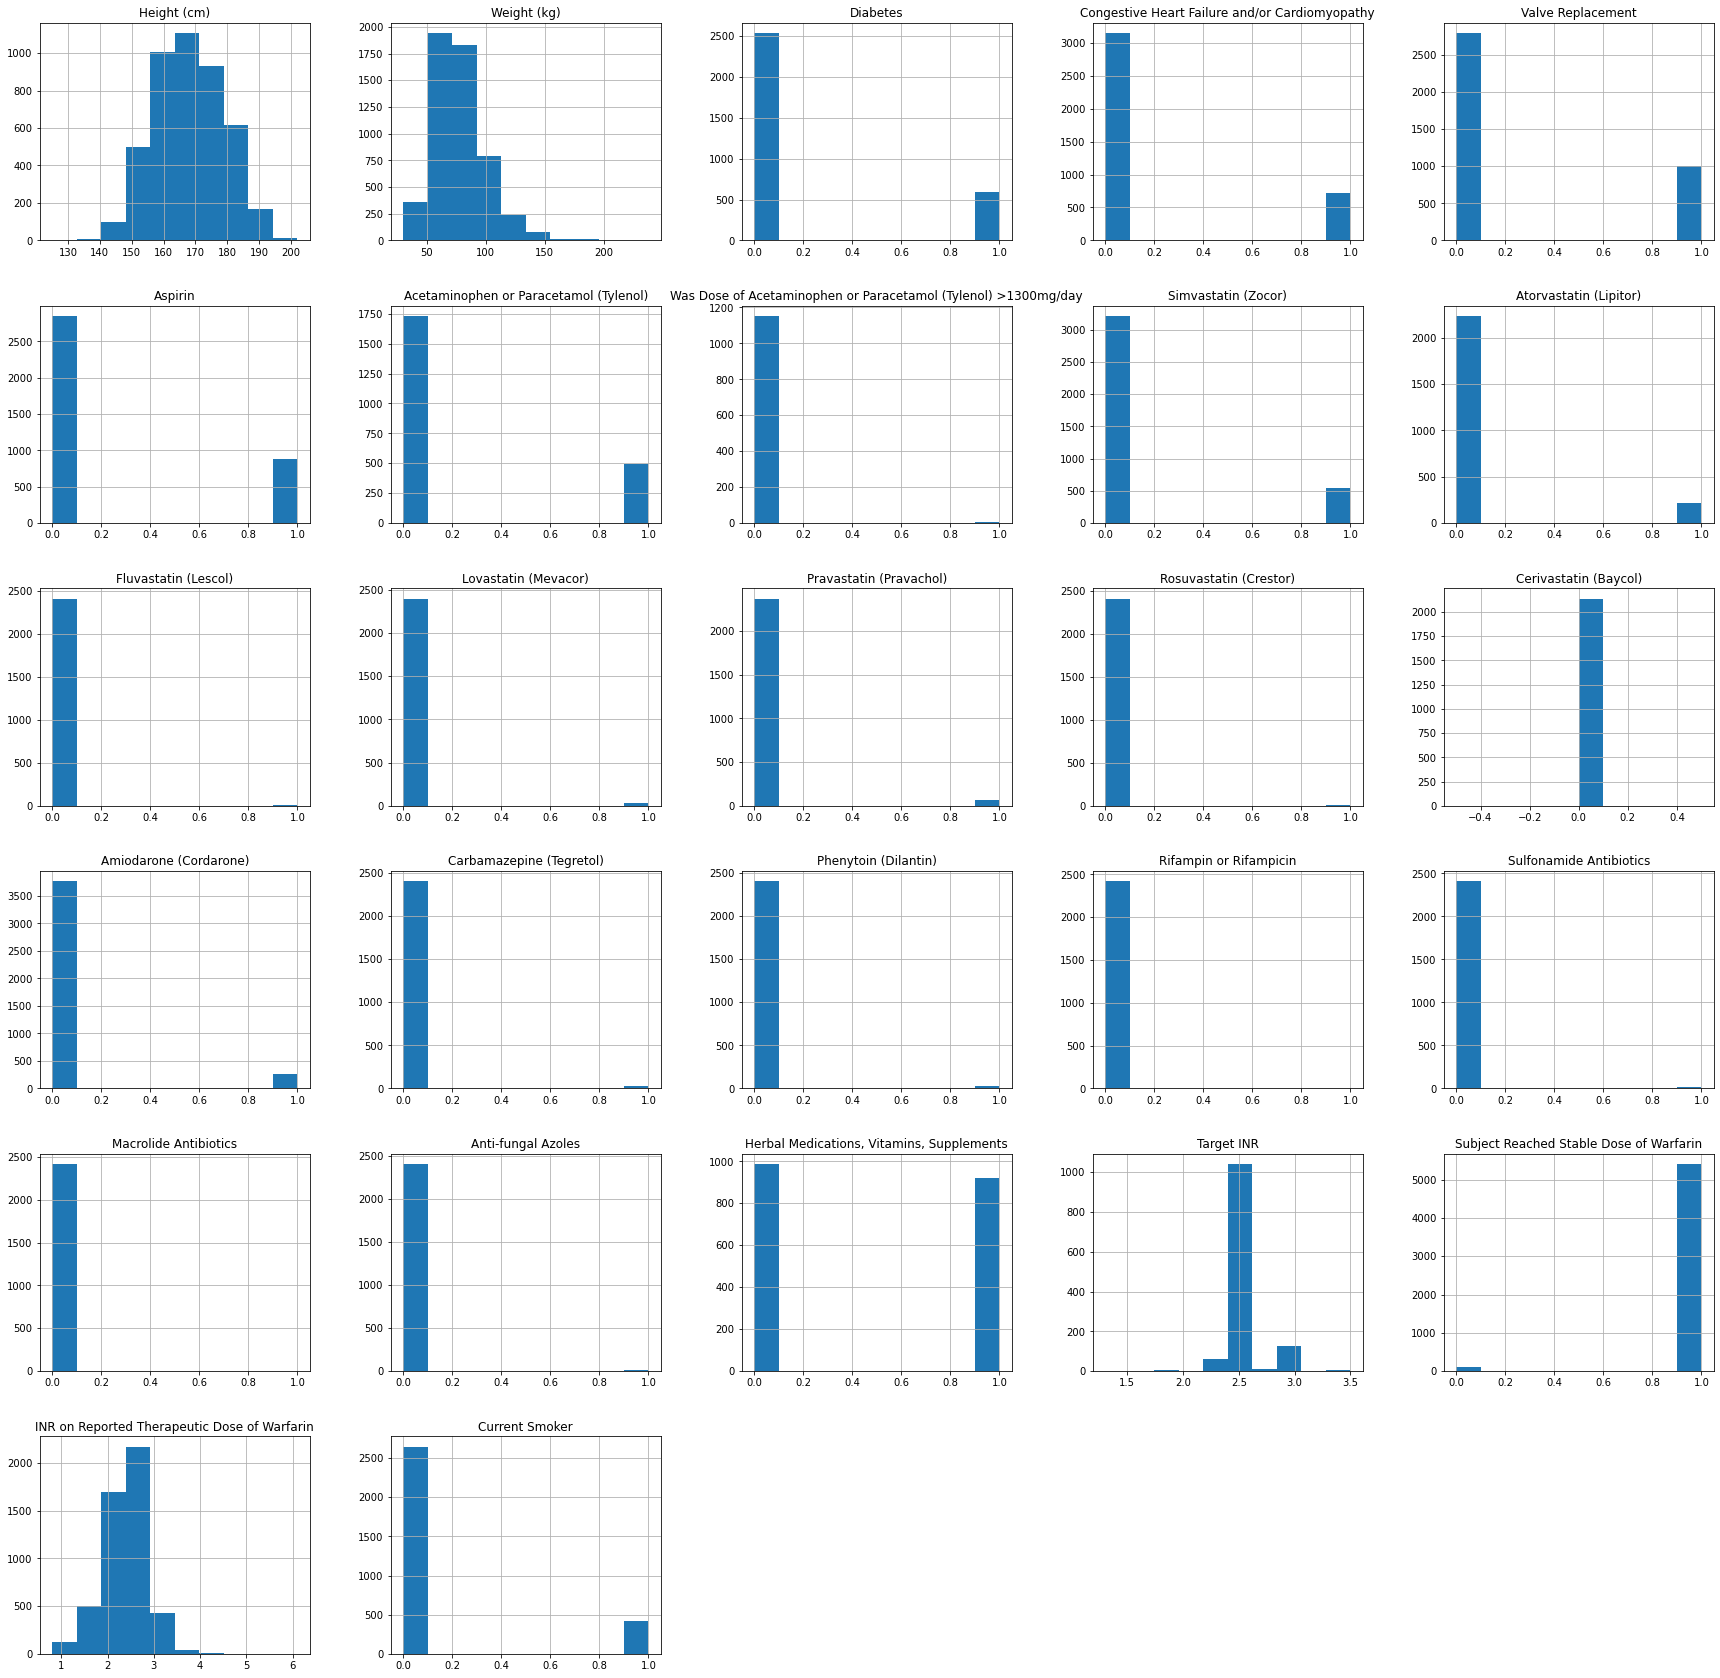

In [24]:
# sada da vidimo graficki prikaz atributa i njihove distribucije
X.hist(figsize=[30,30])
plt.show()

In [25]:
# vidimo da nam vecina atributa ima vrednosti 0 ili 1 (tako su definisani kategoricki atributi - imaju vrednost 0 ako nesto nije
# ispunjeno, a 1 ako jeste), i za njih vidimo koliko ih ima vrednost 0 a koliko 1
# za atribute Height, Weight, Target INR i INR on Reported Therapeutic Dose of Warfarin vidimo da imaju neke kontretne 
# numericke vrednosti - to su nam numericki atributi
# ovde su nam prikazani samo atributi koji su tipa float64

In [26]:
# sada da vidimo korelaciju izmedju atributa
# opet ce nam prikazati korelaciju samo za atribute za koje nam je prikazalo histogram, zato sto su to jedine numericke vrednosti
# korelacija je mera linearne zavisnosti atributa - sto je veca korelacija, veca je linearna zavisnost
# korelacija moze biti broj od 0 do 1, a visa korelacije je npr. preko 0.4 ili 0.5
X.corr()

,Height (cm),Weight (kg),Diabetes,Congestive Heart Failure and/or Cardiomyopathy,Valve Replacement,Aspirin,Acetaminophen or Paracetamol (Tylenol),Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day,Simvastatin (Zocor),Atorvastatin (Lipitor),...,Phenytoin (Dilantin),Rifampin or Rifampicin,Sulfonamide Antibiotics,Macrolide Antibiotics,Anti-fungal Azoles,"Herbal Medications, Vitamins, Supplements",Target INR,Subject Reached Stable Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
Height (cm),1.000000,0.569712,0.075746,0.016712,-0.202121,0.133205,0.068424,-0.026456,0.092251,0.114101,...,0.006895,-0.011995,0.023300,0.025017,0.007778,-0.050005,-0.051440,0.024955,0.182111,0.091719
Weight (kg),0.569712,1.000000,0.211391,0.023198,-0.301615,0.121688,0.215505,-0.015234,0.098710,0.130924,...,0.007292,-0.028653,0.028440,0.047995,0.001939,0.022057,-0.032263,0.023151,0.165188,0.049436
Diabetes,0.075746,0.211391,1.000000,0.159798,-0.138895,0.133570,0.099769,0.046723,0.149445,0.074721,...,0.037641,-0.014340,0.001802,0.018391,0.056666,0.084854,-0.055934,-0.012715,0.011597,0.024111
Congestive Heart Failure and/or Cardiomyopathy,0.016712,0.023198,0.159798,1.000000,-0.054958,0.150716,-0.010878,0.009697,0.105079,0.021180,...,0.012760,0.011569,-0.042117,-0.027504,0.004254,0.013213,-0.001805,-0.009748,-0.030065,0.055075
Valve Replacement,-0.202121,-0.301615,-0.138895,-0.054958,1.000000,-0.200954,-0.200303,0.045758,-0.153297,-0.114819,...,-0.010837,0.029810,-0.039790,-0.029326,-0.031267,-0.135010,0.555825,-0.019612,0.086006,-0.057430
Aspirin,0.133205,0.121688,0.133570,0.150716,-0.200954,1.000000,0.084165,-0.045376,0.185066,0.229752,...,-0.003813,-0.001561,0.011979,-0.011348,0.050097,-0.012386,-0.009996,0.013215,0.004952,0.026444
Acetaminophen or Paracetamol (Tylenol),0.068424,0.215505,0.099769,-0.010878,-0.200303,0.084165,1.000000,0.191530,0.090529,0.036488,...,0.020849,-0.017998,0.032188,-0.020788,-0.011494,0.106203,0.054377,0.069529,0.092533,0.042438
Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day,-0.026456,-0.015234,0.046723,0.009697,0.045758,-0.045376,0.191530,1.000000,-0.012645,-0.014913,...,-0.005419,-0.001626,-0.004315,-0.003257,-0.003986,-0.033372,-0.023304,-0.079545,0.005167,0.061714
Simvastatin (Zocor),0.092251,0.098710,0.149445,0.105079,-0.153297,0.185066,0.090529,-0.012645,1.000000,-0.112722,...,-0.009534,0.009993,-0.005757,0.023580,0.003829,-0.025739,0.014037,0.012887,0.034654,0.026878
Atorvastatin (Lipitor),0.114101,0.130924,0.074721,0.021180,-0.114819,0.229752,0.036488,-0.014913,-0.112722,1.000000,...,0.003428,-0.011794,0.020910,-0.014450,0.038953,0.005295,0.043297,0.043831,0.003597,0.020671


In [27]:
# da vidimo korelacije izmedju numerickih atributa
# usput mozemo da vidimo i korelacije numerickih atributa sa ciljnom promenljivom
X[['Height (cm)', 'Weight (kg)', 'Target INR', 'INR on Reported Therapeutic Dose of Warfarin']].join(y).corr()

,Height (cm),Weight (kg),Target INR,INR on Reported Therapeutic Dose of Warfarin,Therapeutic Dose of Warfarin
Height (cm),1.000000,0.569712,-0.051440,0.182111,0.313890
Weight (kg),0.569712,1.000000,-0.032263,0.165188,0.387648
Target INR,-0.051440,-0.032263,1.000000,0.421728,0.071076
INR on Reported Therapeutic Dose of Warfarin,0.182111,0.165188,0.421728,1.000000,0.188573
Therapeutic Dose of Warfarin,0.313890,0.387648,0.071076,0.188573,1.000000


Vidimo da visina i tezina imaju koeficijent korelacije 0.57. Nisu visoko korelisani, nego su otprilike srednje korelacije. Svakako znamo da visina i tezina cesto zavise jedna od druge - uglavno, sto je neko visi, imace vecu tezinu. 

Kada imamo dva atributa koji su bas visoko korelisani, jedan od njih mozemo eliminisati i ostaviti taj drugi. Na osnovu ove analize, vidimo da necemo izbaciti ni jedan atribut.

Takodje, vidimo da su korelacije numerickih atributa sa ciljnom promenljivom redom 0.31, 0.39, 0.07 i 0.19. To nisu visoke korelacije, pa ni jedan od ovih atributa nije bas dobar prediktor ciljne promeljive.

# Analiza doze leka u odnosu na pol i godine

In [28]:
DF = X[['Gender', 'Age']].join(y, how='inner')
DF.head()

,Gender,Age,Therapeutic Dose of Warfarin
0,male,60 - 69,49.0
1,female,50 - 59,42.0
2,female,40 - 49,53.0
3,male,60 - 69,28.0
4,male,50 - 59,42.0


In [29]:
# pravimo dataframe u kome ce biti samo osobe muskog pola
# brisemo instance koje nemaju podatak o godinama i sortiramo dataframe po godinama

DF_male = DF[DF.Gender == 'male']
DF_male.dropna(subset=['Age'], inplace=True)
DF_male.sort_values('Age', inplace=True)
DF_male

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Gender,Age,Therapeutic Dose of Warfarin
4103,male,10 - 19,26.25
1497,male,10 - 19,42.00
1006,male,10 - 19,33.25
4261,male,10 - 19,24.50
4655,male,10 - 19,45.00
...,...,...,...
753,male,90+,10.50
4230,male,90+,14.00
4995,male,90+,21.00
88,male,90+,49.00


In [30]:
# sada pravimo dataframe u kome ce biti samo osobe zenskog pola
# brisemo instance koje nemaju podatak o godinama i sortiramo dataframe po godinama

DF_female = DF[DF.Gender == 'female']
DF_female.dropna(subset=['Age'], inplace=True)
DF_female.sort_values('Age', inplace=True)
DF_female

C:\Users\Lenovo\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Gender,Age,Therapeutic Dose of Warfarin
2797,female,10 - 19,22.75
4650,female,10 - 19,45.00
3465,female,10 - 19,70.00
3499,female,10 - 19,60.00
5037,female,10 - 19,28.00
...,...,...,...
5017,female,90+,28.00
442,female,90+,35.00
3742,female,90+,24.50
2116,female,90+,16.03


In [31]:
# Sada hocemo da vidimo koja je prosecna doza leka u odnosu na grupe godina
# zato grupisemo po godinama i pravimo liste sa dozama leka za sve razlite opsege godina

In [32]:
df1 = DF_male.groupby('Age')['Therapeutic Dose of Warfarin'].apply(list)
df1

Age
10 - 19                     [26.25, 42.0, 33.25, 24.5, 45.0]
20 - 29    [70.0, 61.25, 52.5, 56.0, 43.83, 31.5, 38.5, 2...
30 - 39    [28.0, 49.0, 35.0, 17.5, 53.75, 36.75, 26.25, ...
40 - 49    [17.5, 28.0, 17.5, 31.5, 24.5, 32.5, 26.53, 21...
50 - 59    [17.5, 57.5, 37.5, 21.0, 39.97, 56.0, 41.75, 7...
60 - 69    [42.0, 70.0, 26.25, 56.0, 21.0, 36.0, 14.0, 65...
70 - 79    [17.5, 10.5, 21.0, 8.75, 21.0, 28.0, 24.5, 12....
80 - 89    [8.75, 11.5, 16.0, 40.0, 157.5, 28.0, 33.0, 45...
90+        [41.04, 15.19, 8.0, 10.5, 14.0, 21.0, 49.0, 27.0]
Name: Therapeutic Dose of Warfarin, dtype: object

In [33]:
average_dosage_male = []

for element in df1:
    average_dosage_male.append(sum(element)/len(element))

average_dosage_male

[34.2,
 43.204339622641506,
 39.037623762376235,
 39.27625100651592,
 36.41561671924288,
 31.21614251512982,
 27.921642780530295,
 27.013573463961613,
 23.21625]

In [34]:
# sada isto ponovimo za osobe zenskog pola 

df2 = DF_female.groupby('Age')['Therapeutic Dose of Warfarin'].apply(list)

average_dosage_female = []

for element in df2:
    average_dosage_female.append(sum(element)/len(element))

average_dosage_female

[40.53,
 42.315367967432195,
 42.378869565217386,
 36.33032520325204,
 32.31303317535545,
 29.05577603330782,
 25.095921429252623,
 24.211404682274246,
 21.883999999999997]

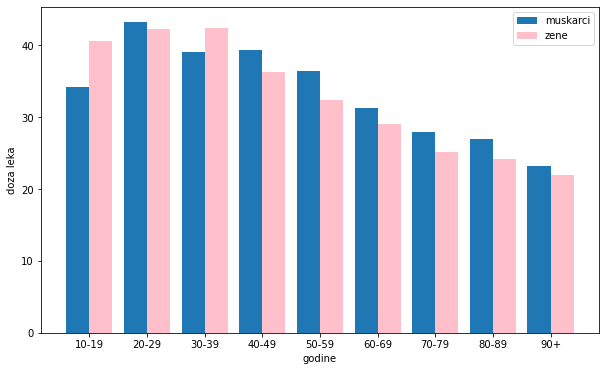

In [35]:
plt.figure(figsize =(10, 6))
plt.bar(np.arange(len(df1)) - 0.2, average_dosage_male, width=0.4, label='muskarci')
plt.bar(np.arange(len(df2)) + 0.2, average_dosage_female, width=0.4, color='pink', label='zene')
plt.xticks(range(0, len(df1)), ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'] )
plt.xlabel('godine')
plt.ylabel('doza leka')
plt.legend(loc='best')
plt.show()

Zakljucujemo da je kod muskaraca od 40 i vise godina potrebna nesto visa doza leka nego kod zena istih godina. To takodje vazi za grupu 20-29 godina. U grupama 10-19 godina i 30-39 godina vidimo da je muskarcima potrebna nesto niza doza nego zenama istih godina.

Takodje, vidimo da se najvisa doza leka prepisuje muskarcima od 20 do 29 godina, a zenama od 30 do 39 godina. Najniza doza leka se pripisuje muskarcima od 90 i vise godina, i to isto vazi i za zene.

# Reprezentacija atributa 

Imamo tri reprezentacije atributa: numericke atribute, atribute cije vrednosti pripadaju nekom opsegu (od - do) i kategoricke atribute. 

In [36]:
numerical_features = ['Height (cm)', 'Weight (kg)', 'Target INR', 'INR on Reported Therapeutic Dose of Warfarin']

In [37]:
binned_features =   ['Age', 'Estimated Target INR Range Based on Indication']

In [38]:
categorical_features = []
for feature in X.columns:
    if feature not in numerical_features and feature not in binned_features:
        categorical_features.append(feature)

In [39]:
# sada popunjavamo NaN vrednosti za numericke atribute
# popunjavamo medijanom
imputer = impute.SimpleImputer(strategy ='median')
imputer.fit(X[numerical_features])
X[numerical_features] = imputer.transform(X[numerical_features])

In [40]:
# sada popunjavamo NaN za atribute cije vrednosti pripadaju nekom opsegu
# vrednosti se pupunjavaju nulom, sto znaci da to polje nedostaje
imputer2 = impute.SimpleImputer(strategy='constant', fill_value='0-missing')
imputer2.fit(X[binned_features])
X[binned_features] = imputer2.transform(X[binned_features])

In [41]:
# sada enkodiramo ordinalno atribute cije vrednosti pripadaju nekom opsegu
ordinal_encoder = preprocessing.OrdinalEncoder()
ordinal_encoder.fit(X[binned_features])
X[binned_features] = ordinal_encoder.transform(X[binned_features])

In [42]:
# sada popunjavamo NaN vrednosti kategorickih atributa
# oznacavamo da to polje nedostaje 
imputer3 = impute.SimpleImputer(strategy='constant', fill_value='missing')
imputer3.fit(X[categorical_features])
X[categorical_features] = imputer3.transform(X[categorical_features])

In [43]:
# da bismo enkodirali kategoricke atribute, moraju svi podaci biti istog tipa
# sve stavljamo da bude tipa string
for feat in categorical_features:
        X[feat] = X[feat].astype(str)

In [44]:
# sada enkodiramo kategoricke atribute 
one_hot_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore',sparse=False)
one_hot_encoder.fit(X[categorical_features])
X_categorical_features_encoded = one_hot_encoder.transform(X[categorical_features])

Sada sva tri dela treba da spojimo u jedno novo X.

In [45]:
data1 = X[numerical_features].values

In [46]:
data2 = X[binned_features].values

In [47]:
data3 = X_categorical_features_encoded

In [48]:
X_final = np.hstack([data1, data2, data3])

In [49]:
# X smo napravili tako da prve 4 kolone budu numericki atributi. To nam je potrebno da znamo, zato sto cemo 
# numericke atribute morati da standardizujemo pre nego sto pocnemo sa treniranjem modela. 

In [50]:
# za modele klasifikacije, y treba da bude 1 ako je vrednost veca od 30, a 0 ako je manja ili jednaka 30
# funkcija astype(int) daje vrednosti 1 ako je uslov u zagradi True, a vrednost 0 ako je False
y_classification = (y>30).astype(int)

In [51]:
y_classification

0       1
1       1
2       1
3       0
4       1
       ..
5695    1
5696    0
5697    1
5698    1
5699    0
Name: Therapeutic Dose of Warfarin, Length: 5528, dtype: int32

In [52]:
# da vidimo koliko imamo elemenata iz obe klase
sum(y_classification == 0)

3124

In [53]:
sum(y_classification == 1)

2404

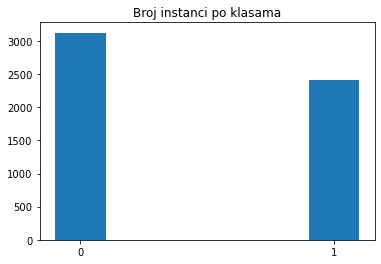

In [54]:
plt.bar([0, 1], [sum(y_classification == 0), sum(y_classification == 1)], width=0.2)
plt.title('Broj instanci po klasama')
plt.xticks([0, 1])
plt.show()

Vidimo da imamo balansiran skup podatke, tj. nemamo znacajno veci broj instanci u jednoj klasi u odnosu na drugu klasu 

In [55]:
# kako imamo naziv promeljive y_classification, promenimo naziv obicnom y u y_regression
y_regression = y

Sada konacno imamo skup podataka X i y (i za klasifikaciju i za regresiju). 

In [56]:
X_final

array([[193.04, 115.7 ,   2.5 , ...,   0.  ,   0.  ,   1.  ],
       [176.53, 144.2 ,   2.5 , ...,   0.  ,   1.  ,   0.  ],
       [162.56,  77.1 ,   2.5 , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [187.96,  97.73,   2.5 , ...,   0.  ,   0.  ,   1.  ],
       [177.8 ,  87.27,   2.5 , ...,   0.  ,   0.  ,   1.  ],
       [190.5 ,  79.55,   2.5 , ...,   0.  ,   0.  ,   1.  ]])

In [57]:
# da bismo u narednoj svesci ucitali X_final, y_regression i y_classification, moramo ih sacuvati, pa ponovo otvoriti 
# u narednoj svesci

In [58]:
%store X_final

Stored 'X_final' (ndarray)


In [59]:
%store y_regression

Stored 'y_regression' (Series)


In [60]:
%store y_classification

Stored 'y_classification' (Series)
